# Multiple linear regression

We will use a car data set and our dependent variable is mpg (miles per gallon) vs our independent variables car weight and length

In [72]:
#Load libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from sklearn.model_selection import train_test_split

In [73]:
#Load Data
data = pd.read_csv("regression_auto.csv")
data.head()

,make,mpg,weight,weight1,price,foreign,repairs,length
0,AMC,22,2930,2.93,4099,0,3,186
1,AMC,17,3350,3.35,4749,0,3,173
2,AMC,22,2640,2.64,3799,0,3,168
3,Audi,17,2830,2.83,9690,1,5,189
4,Audi,23,2070,2.07,6295,1,3,174


# Response and predictor data Summary

In [74]:
data[['mpg','weight1','length']].describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,26.0,20.923077,4.757504,14.00,17.2500,21.0,23.00,35.00
weight1,26.0,3.099231,0.695079,2.02,2.6425,3.2,3.61,4.33
length,26.0,190.076923,18.170136,163.00,173.2500,191.0,203.00,222.00


# Question
Can the weight, its price and whether it’s foreign or not statistically significantly predict a car's miles per gallon?

# Hypothesis
H0: Car weight, its price and whether it’s foreign or not can not  statistically significantly predict a car's miles per gallon
Ha: Car weight, its price and whether it’s foreign or not can statistically significantly predict a car's miles per gallon

The level of significance
alpha = 0.05

# ASSUMPTIONS
Determine if data meets requirements to perform a linear regression.

Assumption #1: Your response variable should be measured on a continuous scale.     
Assumption #2: You have two or more independent variables, which should be measured at the continuous or categorical level.    
Assumption #3: You should have independence of observations (i.e., independence of residuals), which you can check in Stata using the Durbin-Watson statistic.     
Assumption #4: There needs to be a linear relationship between (a) the dependent variable and each of your independent variables, and (b) the dependent variable and the independent variables collectively.         
Assumption #5: Your data needs to show homoscedasticity, which is where the variances along the line of best fit remain similar as you move along the line.       
Assumption #6: Your data must not show multicollinearity, which occurs when you have two or more independent variables that are highly correlated with each other.       
Assumption #7: There should be no significant outliers, high leverage points or highly influential points, which represent observations in your data set that are in some way unusual.      
Assumption #8: The residuals (errors) should be approximately normally distributed.

# Check outliers

In [75]:
def find_outliers(x):
    '''
    sample usage
    data_indices, data_values = find_outliers(x['age'])
    print(np.sort(data_values))
    '''
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor) | (x > ceiling)])
    outlier_values = list(x[outlier_indices])

    return outlier_indices, outlier_values

In [76]:
# Check outliers for mpg
find_outliers(data['mpg'])

([23], [35])

In [77]:
print(data.iloc[23])

make       Datsun
mpg            35
weight       2020
weight1      2.02
price        4589
foreign         1
repairs         5
length        165
Name: 23, dtype: object


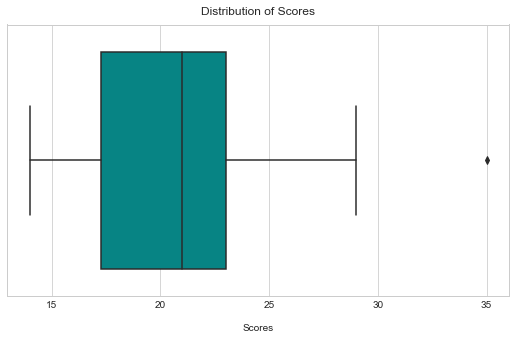

In [78]:
plt.figure(figsize=(9, 5))
sns.boxplot(data['mpg'], color='darkcyan', saturation=0.9)
plt.title("Distribution of Scores", y=1.015)
plt.xlabel("Scores", labelpad=14);

Clearly we have an outlier value of 35 in mpg column

In [79]:
# Check outliers for weight1
find_outliers(data['weight1'])

([], [])

In [80]:
# Check outliers for length
find_outliers(data['length'])

([], [])

In [81]:
#Let's drop the column with outliers
#Dropping the outlier rows with Percentiles
def drop_rows_with_outliers(df, column):
    # 1st quartile (25%)
    Q1 = np.percentile(df[column], 25)
    # 3rd quartile (75%)
    Q3 = np.percentile(df[column],75)
    # Interquartile range (IQR)
    IQR = Q3 - Q1

    # outlier step
    outlier_step = 1.5 * IQR

    df = df[(df[column] < (Q3 + outlier_step)) & (df[column] > (Q1 - outlier_step))]
    return df

In [82]:
print(data.shape)
data=drop_rows_with_outliers(data, 'mpg')
print(data.shape)

(26, 8)
(25, 8)


# Check linearity

Text(0.5, 1.0, 'Linear Relationship Exists between mpg and weight?')

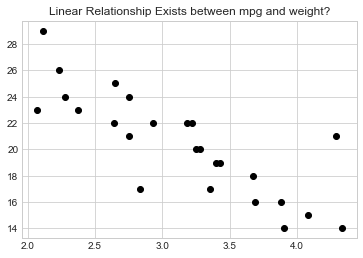

In [83]:
plt.plot(data['weight1'], data['mpg'], 'o', color='black');
plt.title("Linear Relationship Exists between mpg and weight?")

Text(0.5, 1.0, 'Linear Relationship Exists between mpg and length?')

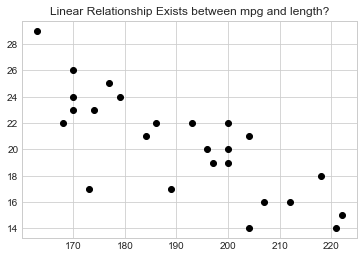

In [84]:
plt.plot(data['length'], data['mpg'], 'o', color='black');
plt.title("Linear Relationship Exists between mpg and length?")

In [85]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results


def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Linear Relationship between the Target and the Features', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, height=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

Linear Relationship between the Target and the Features 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


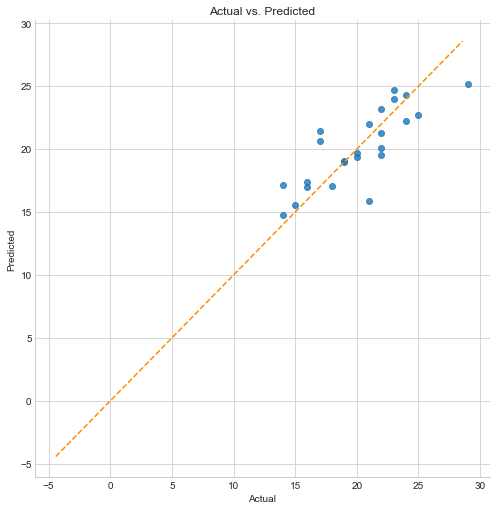

In [86]:
from sklearn.linear_model import LinearRegression
multi_linear_model = LinearRegression()

linear_mX, linear_my = data[['weight1','length']].values, data.mpg.values
Xm_train, Xm_test, Ym_train, Ym_test = train_test_split(linear_mX, linear_my, test_size=1, random_state=100)
multi_linear_model.fit(Xm_train, Ym_train)
linear_assumption(multi_linear_model, Xm_train, Ym_train)

# Check Normality law

In [87]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Are the error terms are normally distributed?', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

Are the error terms are normally distributed? 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.6754669765712111
Residuals are normally distributed


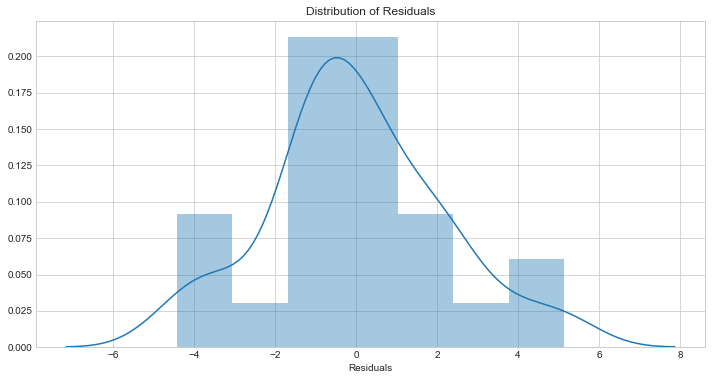


Assumption satisfied


In [88]:
normal_errors_assumption(multi_linear_model, Xm_train, Ym_train)

# Multicollinearity

In [89]:
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')


Assumption 3: Little to no multicollinearity among predictors


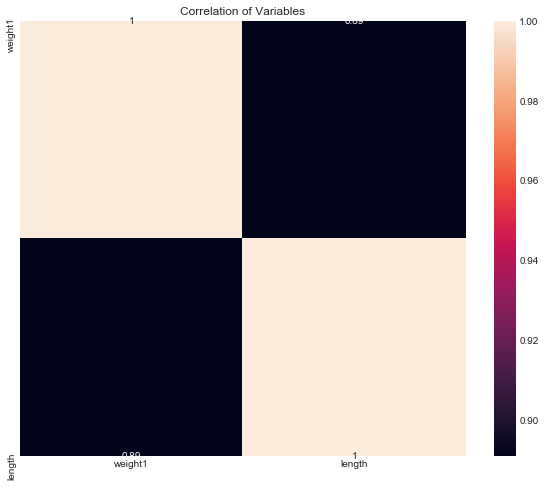

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
weight1: 62.336591849100984
length: 62.336591849100984

2 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption possibly satisfied

Coefficient interpretability may be problematic
Consider removing variables with a high Variance Inflation Factor (VIF)


In [90]:
linear_feature_names = ['weight1','length']
multicollinearity_assumption(multi_linear_model, Xm_train, Ym_train, linear_feature_names)

# No Autocorrelation of the Error Terms (Independence of observations)

In [95]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('-------------------------------------')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')


In [96]:
autocorrelation_assumption(multi_linear_model, Xm_train, Ym_train)

No Autocorrelation 


Performing Durbin-Watson Test
-------------------------------------
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.8680935372817629
Little to no autocorrelation 

Assumption satisfied


# Homoscedasticity

In [93]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


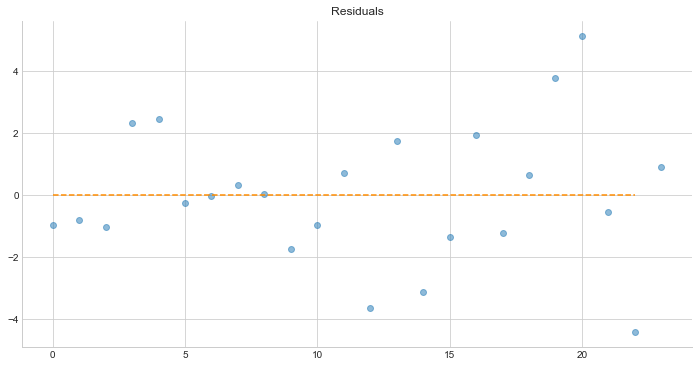

In [94]:
homoscedasticity_assumption(multi_linear_model, Xm_train, Ym_train)

# Multiple linear regression

In [100]:
import statsmodels.formula.api as smf
model = smf.ols("mpg ~ weight1 + length", data= data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     23.17
Date:                Wed, 25 Mar 2020   Prob (F-statistic):           3.85e-06
Time:                        22:06:48   Log-Likelihood:                -54.638
No. Observations:                  25   AIC:                             115.3
Df Residuals:                      22   BIC:                             118.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.5435      7.317      5.678      0.000      26.369      56.719
weight1       -3.3823      1.582     -2.138      0.044      -6.664      -0.101
length        -0.0552      0.060     -0.923      0.366      -0.179       0.069
==============================================================================
Omnibus:                        0.791   Durbin-Watson:                   1.617
Prob(Omnibus):                  0.673   Jarque-Bera (JB):                0.157
Skew:                           0.168   Prob(JB):                        0.924
Kurtosis:                       3.196   Cond. No.                     3.10e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A multiple regression was run to predict mpg (miles covered by the car per gallon) from car weight, its price and whether it’s foreign or not. These variables statistically significantly predicted mpg (miles covered by the car per gallon) , F(2, 22) = 23.17, p < .0005, R2 = .678. But we can see that car weight is the only significant predictor. The regression equation was: predicted miles covered by the car per gallon = 41.544 - 3.382*(weight of the car)-0.055*(Car Length)